In [150]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from IPython.display import Image
from IPython.core.display import HTML 
import datetime
import math
import scipy.optimize as optimize
plt.style.use('ggplot')


To Dos: ML on number of loans pulled form each grade
Show individual security by grade - talk about its limitations
Talk about pooling method & show CI graph = CLT -> approaches normality & easier for us to conduct tests
End with market volume graph on entire dataset

Answer questions using both approaches

Present the simplest method - take the best sharpe ratio class for 2009-2011 and use that for 2012
Present couple other approaches


Rational for taking out the bad classes - we may be trading on noises rather than confident signals
We may be violating the assumptions of t-test, so we can try a non-parametric test
import scipy.optimize as optimize


import scipy.optimize as optimize


def f(params):
    # print(params)  # <-- you'll see that params is a NumPy array
    a, b, c = params # <-- for readability you may wish to assign names to the component variables
    return a**2 + b**2 + c**2

initial_guess = [1, 1, 1]
result = optimize.minimize(f, initial_guess, bounds = [(.25, 1), (-1, 20),(0,1)])
if result.success:
    fitted_params = result.x
    print(fitted_params)
else:
    raise ValueError(result.message)

May want to check average sizes of loans and change proportions accordingly

https://towardsdatascience.com/efficient-frontier-portfolio-optimisation-in-python-e7844051e7f

Still include the IRR calcs 

Weighted average rather than just raw average for the IRR calcs using individual loans


# Premise

We approach EDA from a perspective of an investor, whose interests are maximizing risk-adjusted returns. Here we will look at interest rate vs default rate, and then calculate a net adjusted annual return separated by the loan grade.

Next, we answer the question, are 36 month loans 


Lastly, we will build a model that can create a basket of investments that can outperform the market basket. These are the steps done and assumptions made.

    1. We first calculate the sharpe ratio using net adjusted return on all historical basket of loans. 
    2. We will build a regression model, using features chosen carefully through nested model testing, that will forecast the returns of all the loans in a validation dataset
    3. We will then use linear programming to set constraint and build a portfolio that maximizes the sharpe ratio with 10% of market liquidity
    4. We will then compare our model vs actual result to get a sense of whether we were able to outperform or not 

Additional analysis that can be done is accounting for changes in the risk free rate, and rebalancing of the portfolio year over year.

# Assumptions & Discussions

1. Funded Amount vs Funded Amount Inv: Where there are differences, lending tree stepped in to make up for the differences between loan amount and funed amount invested by investors. We will go ahead and use funded amount as a basis for all our analysis.
2. We assume all cash is deployed on year of x(has the most data) to reduce cash drag. We calculate IRR-> assuming we can reinvest at this rate 
3. Returns on the loans are most likely not normally distributed but a pool of randomly sampled loans should be

# Data Cleansing

As an investor, you want to get a good grasp of two things of any investments, risk and reward. This analyis will mainly focus on that. 

Dissecting the data to too many categorical values can 

First we calculat the default percentage, we will include the "does not meet..." rows as valid loans, and throw out rest of the data that we don't have complete information on.

###data call outs
You can't trade on information that is not there yet.... 


In [2]:
###data load
df = pd.read_csv('./data/loan.csv', low_memory=False)

In [3]:
###cleaning data 
df['last_pymnt_d']=pd.to_datetime(df.last_pymnt_d)
df['issue_d']=pd.to_datetime(df.issue_d)

In [4]:
###fill missing last_payments(no payments) with issue date, may want a separete column for this treatmet
###This is for calculation of IRRs later
df['last_pymnt_d'].fillna(df.issue_d,inplace=True)

In [5]:
###Some pre-processing for ease of calculations
df['issue_yr'] = df.issue_d.dt.year
df['issue_mo']= df.issue_d.dt.month
df['last_pymnt_yr'] = df.last_pymnt_d.dt.year
df['last_pymnt_mo']= df.last_pymnt_d.dt.month

In [6]:
###filter to loans we have complete data only
searchfor = ['Fully Paid', 'Charged Off', 'Default']
df_filtered = df[df['loan_status'].str.contains('|'.join(searchfor))].query("term == ' 36 months' and issue_yr <=2012").copy()

In [7]:
###default flag 
df_filtered['loan_status_flag'] = np.where(df_filtered['loan_status'].str.contains('Fully Paid') ,1,0)

### Overall Default Percentage

In [8]:
1- df_filtered['loan_status_flag'].mean()

0.12997142017682095

### Overall Interest Rate

In [9]:
df_filtered['int_rate'].mean()

12.033947888569795

In [10]:
### IRR Calculations
###calculate differences in months for total duration of the loan 
df_filtered['mo_diff'] = pd.to_numeric((df_filtered['last_pymnt_yr'] - 
                          df_filtered['issue_yr'])*12 + df['last_pymnt_mo'] -df['issue_mo'])
df_filtered['avg_pymnt'] = (df_filtered['total_pymnt']-df_filtered['recoveries'])/(df_filtered['mo_diff']-1)

In [ ]:
##we calculate return using a pool of cash flows 
##avoids IRR's drastic treatment of negative IRR 
##automatically does weighted adjustment based on size of the loan
##we later can take many pools of data using functions built to effectively creat a derivative that is a pool of loans
##Pool of loans returns should be normally distributed, allowing us to do interesting analysis around normality
##and calculate things such as sharpe ratio
##More representative for institutional investors who will have a set of funds for an asset class and not
##investing in individual loans
##Diversification

In [11]:
def cash_flow(row,max_n):
    initial_invest = -row['funded_amnt'] 
    avg_payment = row['avg_pymnt'] or 0 
    num_payments = int(row['mo_diff'])-1 
    fully_paid =row['loan_status_flag'] or 0 
    recovery = row['recoveries'] or 0 
    chargeoff_fee = -row['collection_recovery_fee'] or 0 
    dummy_cfs = int(max_n - row['mo_diff'])+2
    return [initial_invest]+[avg_payment]*num_payments + [recovery+chargeoff_fee]+ [0]*dummy_cfs

In [12]:
def irr_pool(df):
    list_length = df['mo_diff'].max()
    cfs=[]
    for index, row in df.iterrows(): 
        cfs.append(cash_flow(row,list_length))
    result = [sum(x) for x in zip(*cfs)]
    return (np.irr(result)+1)**12 -1

In [13]:
###IRR calculations at an indiviudal loans proved to be a bad exercise, because the bad loans were
###a lot more pronounced. 
def irr_calc(x):  
    ##varible initialization
    initial_invest = -x['funded_amnt']
    avg_payment = x['avg_pymnt']
    num_payments = int(x['mo_diff'])-1
    fully_paid = x['loan_status_flag']
    recovery = x['recoveries']
    chargeoff_fee = -x['collection_recovery_fee']
    ##IRR calculation, input: series of cash flows, total payment evenly divided and spread across the life of the loan 
    return ((np.irr([initial_invest]+[avg_payment]*num_payments + [recovery+chargeoff_fee])+1)**12-1)

In [14]:
def nar_calc(x):

    initial_invest = -x['funded_amnt']
    avg_payment = x['avg_pymnt']
    num_payments = int(x['mo_diff'])   
    fully_paid = x['loan_status_flag']
    charge_off = x['funded_amnt_inv'] - x['total_rec_prncp'] - x['recoveries'] + x['collection_recovery_fee']
    chargeoff_fee = -x['collection_recovery_fee']
    
    balance = x['funded_amnt']
    annual_interest_rate = x['int_rate']/100
    monthly_interest_rate = annual_interest_rate / 12
    monthly_payment = x['installment']
    
    for month in range(1, num_payments):
        if(month != num_payments-1):
            balance = (balance - monthly_payment) * (1 + monthly_interest_rate)
        else: 
            balance = 0
        print('Month: %d \n Minimum monthly payment: %g \n Remaining balance: %g'\
              % (month, round(monthly_payment, 2), round(balance,2)))

### Pooled Method Overall IRR

In [15]:
irr_pool(df_filtered)

0.07708614688635329

In [16]:
##NaNs returned from IRRs with 0 payments should be -100% return 
df_filtered['irr']=df_filtered.apply(irr_calc, axis=1)

### Weighed Average of security level IRRs

In [17]:
##NaNs returned from IRRs with 0 payments should be -100% return 
df_filtered['irr']=df_filtered['irr'].replace(np.NaN,-1)

In [18]:
weighted_avg = np.average(df_filtered['irr'], weights=df_filtered['funded_amnt'])
weighted_avg

0.068881413393099555

In [19]:
df_filtered[(df_filtered['loan_status_flag']==1) ][['loan_amnt','last_pymnt_amnt','installment','issue_d','int_rate'
                                                 ,'last_pymnt_d', 'total_pymnt','mo_diff','avg_pymnt','irr'
                                                ,'collection_recovery_fee','recoveries','total_rec_late_fee']].head(25)

,loan_amnt,last_pymnt_amnt,installment,issue_d,int_rate,last_pymnt_d,total_pymnt,mo_diff,avg_pymnt,irr,collection_recovery_fee,recoveries,total_rec_late_fee
0,5000.0,171.62,162.87,2011-12-01,10.65,2015-01-01,5861.071414,37.0,162.807539,0.111582,0.0,0.0,0.00
2,2400.0,649.91,84.33,2011-12-01,15.96,2014-06-01,3003.653644,30.0,103.574264,0.204687,0.0,0.0,0.00
3,10000.0,357.48,339.31,2011-12-01,13.49,2015-01-01,12226.302212,37.0,339.619506,0.144298,0.0,0.0,16.97
5,5000.0,161.03,156.46,2011-12-01,7.90,2015-01-01,5631.377753,37.0,156.427160,0.081812,0.0,0.0,0.00
7,3000.0,111.34,109.43,2011-12-01,18.64,2015-01-01,3938.144334,37.0,109.392898,0.202945,0.0,0.0,0.00
11,12000.0,6315.30,402.54,2011-12-01,12.69,2013-09-01,13943.080000,21.0,697.154000,0.191938,0.0,0.0,0.00
13,3000.0,102.43,96.68,2011-12-01,9.91,2015-01-01,3478.981915,37.0,96.638387,0.103444,0.0,0.0,0.00
15,1000.0,36.32,35.31,2011-12-01,16.29,2015-01-01,1270.171106,37.0,35.282531,0.175212,0.0,0.0,0.00
16,10000.0,370.46,347.98,2011-12-01,15.27,2015-01-01,12519.260450,37.0,347.757235,0.163339,0.0,0.0,0.00
17,3600.0,583.45,109.57,2011-12-01,6.03,2013-05-01,3785.020000,17.0,236.563750,0.073885,0.0,0.0,0.00


In [20]:
df_group = df_filtered.groupby(['grade','issue_yr'])
df_group_irr = df_group.apply(irr_pool)

### Pooled Method IRR Buckets

In [21]:
df_group_irr

grade  issue_yr
A      2007        0.085894
       2008        0.052998
       2009        0.066634
       2010        0.061765
       2011        0.052406
       2012        0.051728
B      2007       -0.018204
       2008        0.022719
       2009        0.057404
       2010        0.076873
       2011        0.082959
       2012        0.082088
C      2007        0.007516
       2008        0.004002
       2009        0.063086
       2010        0.089088
       2011        0.086319
       2012        0.092011
D      2007       -0.016531
       2008       -0.021723
       2009        0.073915
       2010        0.090750
       2011        0.111342
       2012        0.110619
E      2007       -0.019496
       2008        0.022313
       2009        0.053603
       2010        0.094466
       2011        0.140383
       2012        0.133457
F      2007       -0.143671
       2008       -0.055813
       2009        0.017345
       2010        0.007917
       2011        0.104254
    

In [22]:
df_group_irr.argmax()

('G', 2012)

In [23]:
df_group_irr.max()

0.22148499252234632

### Individual Security IRR Weighted Average Method

In [24]:
df_group_irr = df_group.apply(lambda x: np.average(x['irr'],weights = x['funded_amnt']))
df_group_irr.argmax()

('G', 2012)

In [25]:
df_group_irr.max()

0.22895176203851611

In [ ]:
###may want to pool by size of portfolio not n random 

In [26]:
def pool(df,pool_size):  
    pool_running = 0 
    df_pool = df.copy()
    df_out = pd.DataFrame()
    while (pool_running < pool_size):
        df_subset = df_pool.sample(1)
        ###no replacement
        df_pool = df_pool.drop(df_subset.index)
        pool_running += df_subset.iloc[0]['funded_amnt']
        df_out = df_out.append(df_subset)
    return df_out

In [27]:
def collect_n(df,n,pool_size):
    returns_list = []
    for x in range(0,n):
        df_out = pool(df,pool_size)
        returns_list.append(irr_pool(df_out))   
    return returns_list

In [28]:
def collect_n_random(df,n,size):
    returns_list = []
    for x in range(0,n):
        df_out = df.sample(size)
        returns_list.append(irr_pool(df_out))   
    return returns_list

In [29]:
def collect_n_random_stats(df,n,size):
    returns_list = []
    for x in range(0,n):
        df_out = df.sample(size)
        returns_list.append(irr_pool(df_out))   
    return [np.average(returns_list)] +[math.sqrt(np.var(returns_list))]

In [31]:
#out=collect_n(df_filtered,100,10000000)

In [32]:
out=collect_n_random(df_filtered,100,1000)

In [34]:
out=collect_n_random_stats(df_filtered,100,1000)

In [38]:
out

[0.07742042070855211, 0.007487511760440712]

In [135]:
df_conf_int = df_filtered.groupby(['issue_yr','grade'])['irr'].describe()
df_conf_int


count      mean       std       min       25%       50%  \
issue_yr grade                                                              
2007     A         78.0  0.088713  0.079546 -0.500594  0.079421  0.086102   
         B         98.0 -0.006549  0.320001 -1.000000  0.093338  0.102290   
         C        141.0 -0.021995  0.324978 -1.000000  0.102903  0.117951   
         D         99.0 -0.054633  0.371228 -0.997184 -0.119874  0.136134   
         E        100.0 -0.055435  0.397073 -0.999364 -0.230600  0.150825   
         F         52.0 -0.208138  0.486583 -1.000000 -0.677446  0.161972   
         G         35.0 -0.123116  0.479978 -0.999264 -0.696737  0.187460   
2008     A        318.0  0.051919  0.212556 -1.000000  0.085216  0.092391   
         B        594.0  0.000464  0.315904 -1.000000  0.101580  0.113053   
         C        580.0 -0.015033  0.352817 -1.000000  0.115918  0.129273   
         D        419.0 -0.045971  0.396158 -1.000000  0.006673  0.144893   
         E        285.0 -0.015584  0.390134 -1.000000 -0.024199  0.162566   
         F        111.0 -0.091713  0.467851 -1.000000 -0.429206  0.174563   
         G         86.0 -0.016267  0.419798 -1.000000 -0.197372  0.200943   
2009     A       1203.0  0.061541  0.198972 -1.000000  0.087710  0.099746   
         B       1445.0  0.046640  0.300500 -1.000000  0.122036  0.132508   
         C       1348.0  0.047080  0.327412 -1.000000  0.138711  0.149275   
         D        817.0  0.054980  0.337789 -1.000000  0.154649  0.165910   
         E        308.0  0.026366  0.404015 -1.000000  0.168587  0.184987   
         F        105.0  0.025176  0.415514 -1.000000  0.131947  0.207951   
         G         55.0  0.020261  0.427598 -1.000000 -0.065891  0.220651   
2010     A       2567.0  0.057046  0.164388 -1.000000  0.073332  0.081749   
         B       2805.0  0.066571  0.242776 -1.000000  0.108856  0.122915   
         C       2070.0  0.072541  0.291635 -1.000000  0.139917  0.152833   
         D       1253.0  0.056088  0.342713 -1.000000  0.158380  0.169487   
         E        336.0  0.059441  0.365993 -1.000000  0.175016  0.191473   
         F         91.0  0.007993  0.436437 -1.000000 -0.052855  0.208944   
         G         34.0 -0.026133  0.475982 -1.000000 -0.255133  0.229336   
2011     A       5579.0  0.040826  0.199763 -1.000000  0.069236  0.081777   
         B       4722.0  0.067668  0.246652 -1.000000  0.111112  0.126696   
         C       2203.0  0.061429  0.315587 -1.000000  0.141732  0.156778   
         D       1261.0  0.077752  0.331987 -1.000000  0.163948  0.182590   
         E        272.0  0.079617  0.358213 -1.000000  0.177130  0.210615   
         F         54.0  0.090646  0.369825 -1.000000  0.199155  0.232893   
         G         10.0 -0.037985  0.482569 -0.982824 -0.251553  0.223436   
2012     A      10741.0  0.043223  0.215096 -1.000000  0.077788  0.090497   
         B      16757.0  0.071294  0.268929 -1.000000  0.120703  0.143327   
         C       9866.0  0.075351  0.330121 -1.000000  0.156624  0.176174   
         D       5063.0  0.090002  0.365960 -1.000000  0.190087  0.210613   
         E        790.0  0.114368  0.385105 -1.000000  0.213854  0.243862   
         F        103.0  0.110739  0.458496 -1.000000  0.241808  0.267296   
         G         24.0  0.200639  0.454886 -0.999928  0.278873  0.314731   

                     75%       max  
issue_yr grade                      
2007     A      0.125100  0.173158  
         B      0.116177  0.198256  
         C      0.125394  0.241789  
         D      0.150054  0.260987  
         E      0.159527  0.311236  
         F      0.177556  0.316515  
         G      0.210372  0.487778  
2008     A      0.115504  0.208588  
         B      0.133019  0.456843  
         C      0.144625  0.276075  
         D      0.157520  0.301284  
         E      0.183181  0.353325  
         F      0.195775  0.364033  
         G      0.212628  0.376854  
2009     A      0.121434  0.231552  


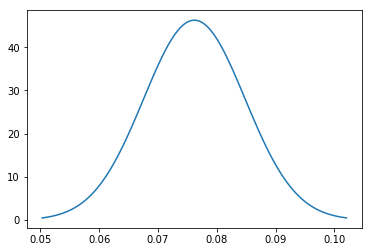

In [33]:
mu = np.average(out)
variance = np.var(out)
sigma = math.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x,mlab.normpdf(x, mu, sigma))
plt.show()

In [ ]:
cust = lambda g: collect_n_random_stats

In [85]:
df_group = df_filtered.groupby(['issue_yr'])
df_group.count()
df_sharpe =df_group.apply(lambda x: collect_n_random_stats(x,100,100))
#df_group_irr = df_group.apply(lambda x:collect_n_random_stats(x,10,np.min(1000, x.count().loc[0]/10)))

AttributeError: 'Series' object has no attribute 'columns'

In [102]:
mean = [sublist[0] for sublist in df_sharpe.values]
stdev = [sublist[1] for sublist in df_sharpe.values]

In [101]:
df_sharpe.values

array([list([-0.021994030681171541, 0.035105320861345504]),
       list([0.012029604236237019, 0.03750651742601825]),
       list([0.065858730807501459, 0.026245380469597266]),
       list([0.077805637952297529, 0.022353631333799848]),
       list([0.075162485450149502, 0.021103132367924656]),
       list([0.083078250625224129, 0.025157282018253565])], dtype=object)

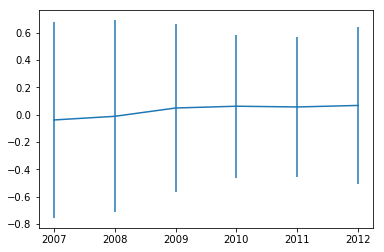

In [107]:
####Confidence Intervals on IRR of overall market
df_conf_int = df_filtered.groupby(['issue_yr'])['irr'].describe()
# example data
x = df_conf_int.index
y = df_conf_int['mean']
yerr = df_conf_int['std']*2
fig, ax = plt.subplots()
ax.errorbar(x, y, yerr=yerr)
plt.show()




In [68]:
df_group = df_filtered.groupby(['issue_yr'])
df_sharpe =df_group.apply(lambda x: collect_n_random_stats(x,100,100))
#df_group_irr = df_group.apply(lambda x:collect_n_random_stats(x,10,np.min(1000, x.count().loc[0]/10)))

In [84]:
mean = [sublist[0] for sublist in df_sharpe.values]
stdev = [sublist[1] for sublist in df_sharpe.values]

[0.0069959368306351296, 0.03490798222429893]

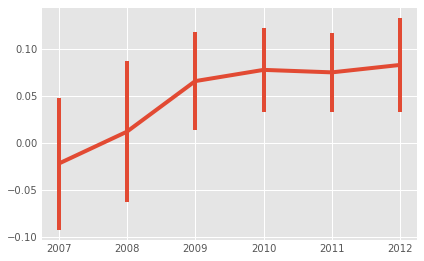

In [124]:
x = df_sharpe.index
y = [sublist[0] for sublist in df_sharpe.values]
yerr = [sublist[1]*2 for sublist in df_sharpe.values]
fig, ax = plt.subplots()
ax.errorbar(x, y,  yerr=yerr)






In [148]:
df_filtered_year = df_filtered[(df_filtered['issue_yr'] >=2009) & (~df_filtered['grade'].isin(['F','G']))].copy()
df_group_grade = df_filtered_year.groupby(['issue_yr','grade'])
df_sharpe_grade =df_group_grade.apply(lambda x: collect_n_random_stats(x,100,100))


In [149]:
df_sharpe_grade

issue_yr  grade
2009      A        [0.0688505576663, 0.015858195765848362]
          B        [0.0573407476198, 0.028003886412191543]
          C        [0.0657707165657, 0.028113362135889605]
          D        [0.0758069795791, 0.025504547667911808]
          E        [0.0522236834097, 0.029799445884017478]
2010      A        [0.0622168833716, 0.011475527085663262]
          B        [0.0768044736296, 0.020938987098078548]
          C        [0.0899831129427, 0.023518947934158346]
          D         [0.089723306613, 0.027768986640094567]
          E        [0.0922577087941, 0.025426155245442464]
2011      A         [0.0501762758909, 0.01705806443081306]
          B         [0.0821554139735, 0.01946972545873796]
          C         [0.0803901872347, 0.02584361105208549]
          D         [0.114915744066, 0.023029188479757153]
          E          [0.13938548677, 0.016054701323236338]
2012      A        [0.0480873066226, 0.021059367227982663]
          B         [0.0824232125945, 0.

In [140]:
x=df_filtered.loc[df_filtered['irr'].argmax()]
initial_invest = -x['funded_amnt']
avg_payment = x['avg_pymnt']
num_payments = int(x['mo_diff'])-1    
fully_paid = x['loan_status_flag']
recovery = x['recoveries']
chargeoff_fee = -x['collection_recovery_fee']
x['total_pymnt']
x['recoveries']

1516.3800000000001

In [ ]:
##Portfolio Optimization


In [ ]:
def f(params):
    # print(params)  # <-- you'll see that params is a NumPy array
    a, b, c = params # <-- for readability you may wish to assign names to the component variables
    return a**2 + b**2 + c**2

initial_guess = [1, 1, 1]
result = optimize.minimize(f, initial_guess, bounds = [(.25, 1), (-1, 20),(0,1)])
if result.success:
    fitted_params = result.x
    print(fitted_params)
else:
    raise ValueError(result.message)

In [ ]:
###appendix

##limitation of individual IRR
### 3 years is too much of a delay, cosnider a strategy where you hold for 12 months & sell.
### This allows better modeling
